CMPU 250 | Class 1 | Intro to NumPy and Pandas

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn as sk

In [10]:
# load cleaned data
# df = pd.read_csv("/Users/erin/Downloads/cleaned_dutchess_data.csv")
df = pd.read_csv("cleaned_dutchess_data.csv")
df_original = df.copy()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   action_taken                       2748 non-null   int64  
 1   derived_race                       2748 non-null   object 
 2   derived_ethnicity                  2748 non-null   object 
 3   applicant_sex                      2748 non-null   int64  
 4   applicant_age                      2748 non-null   object 
 5   income                             2684 non-null   float64
 6   debt_to_income_ratio               2234 non-null   object 
 7   applicant_credit_score_type        2748 non-null   int64  
 8   loan_amount                        2748 non-null   float64
 9   loan_to_value_ratio                2219 non-null   object 
 10  interest_rate                      2068 non-null   object 
 11  rate_spread                        1874 non-null   objec

,action_taken,derived_race,derived_ethnicity,applicant_sex,applicant_age,income,debt_to_income_ratio,applicant_credit_score_type,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,loan_type,loan_purpose,lien_status,property_value,occupancy_type,tract_minority_population_percent,aus-1,denial_reason-1
0,1,Black or African American,Not Hispanic or Latino,2,45-54,104.0,37,1,395000.0,96.5,7.125,1.054,2,1,1,405000,1,21.09,3,10
1,1,White,Not Hispanic or Latino,1,45-54,79.0,50%-60%,2,255000.0,96.5,6.25,0.458,2,1,1,265000,1,63.55,3,10
2,1,White,Hispanic or Latino,1,35-44,133.0,42,3,455000.0,96.999,6.25,0.007,1,1,1,465000,1,26.05,1,10
3,1,White,Joint,1,35-44,101.0,47,3,405000.0,82.425,6.375,-0.132,1,1,1,495000,1,20.03,2,10
4,5,White,Not Hispanic or Latino,2,<25,101.0,NaN,9,275000.0,NaN,NaN,NaN,1,1,1,NaN,1,25.14,6,10


In [11]:
df.describe()

,action_taken,applicant_sex,income,applicant_credit_score_type,loan_amount,loan_type,loan_purpose,lien_status,occupancy_type,tract_minority_population_percent,aus-1,denial_reason-1
count,2748.000000,2748.000000,2684.000000,2748.000000,2.748000e+03,2748.000000,2748.0,2748.000000,2748.000000,2748.000000,2748.000000,2748.000000
mean,1.918122,1.429767,183.637481,46.583697,3.628239e+05,1.169214,1.0,1.009825,1.113173,30.510972,45.245997,34.889374
std,1.466602,0.529248,350.398381,213.266244,2.751677e+05,0.443501,0.0,0.098653,0.431640,13.649407,213.520585,166.216943
min,1.000000,1.000000,0.000000,1.000000,5.000000e+03,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,90.000000,2.000000,2.450000e+05,1.000000,1.0,1.000000,1.000000,21.560000,1.000000,10.000000
50%,1.000000,1.000000,125.000000,3.000000,3.250000e+05,1.000000,1.0,1.000000,1.000000,28.840000,2.000000,10.000000
75%,3.000000,2.000000,182.250000,9.000000,4.250000e+05,1.000000,1.0,1.000000,1.000000,34.990000,5.000000,10.000000
max,8.000000,6.000000,9000.000000,1111.000000,7.005000e+06,4.000000,1.0,2.000000,3.000000,86.570000,1111.000000,1111.000000


In [12]:
df.nunique()

,0
action_taken,8
derived_race,8
derived_ethnicity,5
applicant_sex,4
applicant_age,8
income,430
debt_to_income_ratio,20
applicant_credit_score_type,10
loan_amount,123
loan_to_value_ratio,710


**Variable Descriptions**

action_taken: Categorical outcome indicating the decision on the loan application. 1 (Loan originated), 2 (Application approved but not accepted), 3 (Application denied), 4 (Application withdrawn by applicant), 5 (File closed for incompleteness), 6 (Purchased loan).

derived_race: Categorical variable describing the race or ethnicity (string)

applicant_age: Categorical explanatory variable describing the age range of the applicant. (String) For example : '<25', '25-34', '35-44', '45-54', '55-64', and '>65'.

income: Continuous variable representing the applicant’s annual income in thousands of dollars. (Float)

debt_to_income_ratio: Categorical variable indicating the applicant’s debt-to-income ratio as a percentage range. (String) Example : '<20%', '20%-<30%', '30%-<36%', '36%-<40%', '40%-<45%', '45%-<50%', '50%-60%', and '>60%'.

loan_amount: Continuous variable representing the loan amount requested in dollars. (int)

loan_to_value_ratio: Continuous variable indicating the loan-to-value ratio as a percentage. (Float)

interest_rate: Continuous variable representing the interest rate on the loan as a percentage. (Float)

rate_spread: Continuous variable indicating the difference between the loan’s interest rate and the average prime offer rate. (Float)

loan_type: Categorical variable describing the type of loan. (Int) 1 (Conventional), 2 (FHA), 3 (VA), 4 (RHS or FSA).

loan_purpose: Categorical variable indicating the purpose of the loan. (Int) 1 (Home purchase), 2 (Home improvement), 31 (Refinancing), 32 (Cash-out refinancing), 4 (Other purpose), 5 (Not applicable).

lien_status: Categorical variable describing the lien status of the loan. (Int) 1 (First lien), 2 (Subordinate lien).

property_value: Continuous variable representing the value of the property in dollars. (Int)

occupancy_type: Categorical variable indicating the occupancy type of the property. (Int) 1 (Principal residence), 2 (Second residence), 3 (Investment property).

tract_minority_population_percent: Continuous variable representing the percentage of the census tract’s population that identifies as a minority. (Float)

aus-1: Categorical variable indicating the automated underwriting system used. (Int) 1 (Desktop Underwriter), 2 (Loan Prospector), 3 (Technology Open to Approved Lenders), 4 (Guaranteed Underwriting System), 5 (Other), 6 (Not applicable).

denial_reason-1: Categorical variable indicating the primary reason for loan denial, if applicable. (Int) 1 (Debt-to-income ratio), 2 (Employment history), 3 (Credit history), 4 (Collateral), 5 (Insufficient cash), 6 (Unverifiable information), 7 (Credit application incomplete), 8 (Mortgage insurance denied), 9 (Other), 10 (Not applicable)


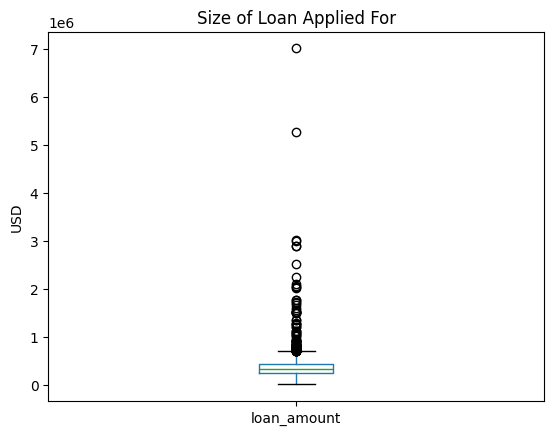

In [13]:
# boxplot for loan amount
df.boxplot('loan_amount', grid=False)

plt.title('Size of Loan Applied For')
plt.ylabel('USD')
plt.show()

There appear to be two extreme outliers in the data, so we will temporarily remove them to better examine the trend.

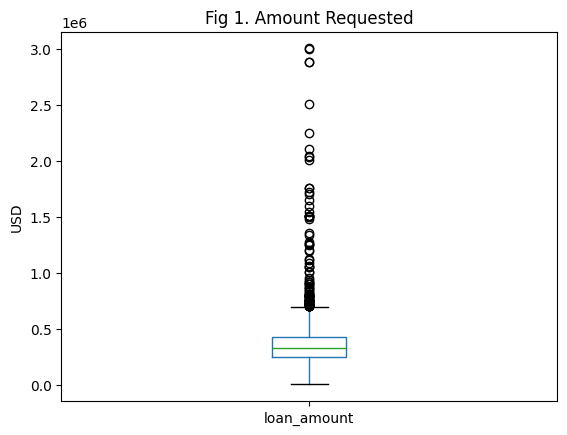

In [14]:
# find outlier values
df.sort_values(by="loan_amount")

# remove largest outliers
df = df[df['loan_amount'] < 4000000]

# re-plot
df.boxplot('loan_amount', grid=False)
plt.title('Fig 1. Amount Requested')
plt.ylabel('USD')
plt.show()

In Figure 1, we can see that the distribution of loan values applied for appears to be symmetrical,
with no skew. This indicates that in Dutchess County in 2023, there were just as many small loans
requested as larger loans. However, there are many outliers on the upper range of the distribution,
which would indicate that a few applicants requested very large sums of money.

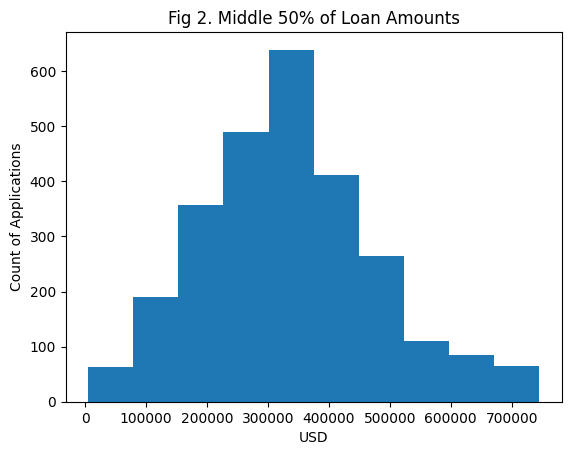

In [15]:
# plot a histogram showing the breakdown of loan values beneath the 75th percentile
df_filtered = df[df['loan_amount'] < 750000]
df_filtered.hist('loan_amount', grid=False)
plt.title('Fig 2. Middle 50% of Loan Amounts')
plt.ylabel('Count of Applications')
plt.xlabel('USD')
plt.show()

In Figure 2, we looked at the interquartile range and used the box values to
focus on where most of the data lie. Here we can see that once the especially
large loans are removed, there's a normal distribution centered somewhere
around $350,000.

In [16]:
# transform derived race to binary column for white or Black
df['binary_race'] = 0
df.loc[df['derived_race'] == "White", 'binary_race'] = 1

# transform derived ethnicity to binary column for Hispanic or not
df['binary_ethnicity'] = 0
df.loc[df['derived_ethnicity'] == "Not Hispanic or Latino", 'binary_ethnicity'] = 1

# create column with 0 for denied applications/preapproval requests and 1 for accepted applications
df['binary_denied'] = 0
df.loc[(df['action_taken'] == 3) | (df['action_taken'] == 7), 'binary_denied'] = 1

# create correlation matrix
df_corr = df[['applicant_sex','binary_race','binary_ethnicity','binary_denied']]
df_corr.corr()

,applicant_sex,binary_race,binary_ethnicity,binary_denied
applicant_sex,1.000000,-0.059905,-0.016842,0.011389
binary_race,-0.059905,1.000000,-0.030782,-0.061120
binary_ethnicity,-0.016842,-0.030782,1.000000,-0.060356
binary_denied,0.011389,-0.061120,-0.060356,1.000000


To investigate our hypothesis about loan outcomes being racially biased, we classified each application as being submitted by a white person or a person of color, and by someone Hispanic or not Hispanic. Then we looked for a correlation between the identity information and the outcome. In the 'action_taken' field, a value of 3 indicates the application was denied and 7 indicates that a preapproval requested was denied.

This matrix shows no evidence of strong correlation.

In [17]:
# remove non-numeric values from interest column, such as "exempt"
df = df[pd.to_numeric(df['interest_rate'], errors='coerce').notnull()]

# create correlation matrix
df_corr = df[['tract_minority_population_percent','loan_to_value_ratio','interest_rate']]
df_corr.corr()

,tract_minority_population_percent,loan_to_value_ratio,interest_rate
tract_minority_population_percent,1.000000,0.094469,0.068356
loan_to_value_ratio,0.094469,1.000000,0.023897
interest_rate,0.068356,0.023897,1.000000


Another useful variable for examining bias is the tract_minority_population_percent which was added to the HDMA data from the US Census Bureau. The value is a percentage from 0 to 100 describing the relative size of the minority population in the area of the loan application. Here we compared its variance with outcome variables: the interest rate, and the loan to value ratio.

This matrix shows no evidence of strong correlation.

In [18]:
# count occurrences of each denial reason
counts = df['denial_reason-1'].value_counts()

# remove 'Not applicable' and 'Exempt' entries
counts = counts.drop(labels=[10,1111])

denial_reasons = ['Debt-to-income ratio','Credit history','Collateral','Other','Credit application incomplete','Insufficient cash','Unverifiable information','Employment history','Mortgage insurance denied']

# plot reasons
plt.barh(denial_reasons, counts)
plt.ylabel('Denial Reason')
plt.xlabel('Count of Applications')
plt.title('Frequency of Loan Denial Reasons')
plt.show()

KeyError: '[1111] not found in axis'

This bar plot shows the most common reasons for a loan application to be denied. We can see that the applicant's monthly debt-to-income ratio (usually a value between 20% and 60%) is the most likely cause of rejection, accounting for as many cases as the next two causes combined. Therefore, low-income neighborhoods whixh are targeted by predatory lending companies may face the most difficulty in achieving home ownership.

In [19]:
df = df.dropna(subset=['income', 'tract_minority_population_percent'])

X = df[['tract_minority_population_percent']]
y = df['income']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     16.55
Date:                Fri, 28 Mar 2025   Prob (F-statistic):           4.93e-05
Time:                        12:52:48   Log-Likelihood:                -13798.
No. Observations:                1932   AIC:                         2.760e+04
Df Residuals:                    1930   BIC:                         2.761e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

The linear regression was applied to check if low income neighborhoods generally have more minority applicants. Because in previous analysis, we found that loans are often denied due to low income. If the linear regression explains a lot of the variation and is statistically signifiant, then lending companies may be targeting minorities indirectly. However, we had a small R^2 value of 0.01 and a small P-value. So the linear regression models show that the predictors are statistically signifiant, but explain very little of the variance in income.

Create a new variable to see if the loan given out has a higher than the median interest rate attached to it or a lower than the median interest rate.

In [20]:
# make interest rate values numeric from strings
df['interest_rate'] = pd.to_numeric(df['interest_rate'], errors='coerce')

# calculate median interest rate
median_interest_rate = df['interest_rate'].median()
print(f"Median interest rate: {median_interest_rate}")

# new binary variable 1 if interest_rate is above the median, 0 otherwise
df['high_interest_rate'] = 0
df.loc[df['interest_rate'] > median_interest_rate, 'high_interest_rate'] = 1

print(df['high_interest_rate'].value_counts())

Median interest rate: 6.625
high_interest_rate
0    1044
1     888
Name: count, dtype: int64


Run a  logistic regression to see if the applicant's sex or gender are good predictors of whether the interest rate is higher than the median or lower.

In [21]:
# logistic regression
model = smf.logit(formula='high_interest_rate ~ C(applicant_sex) + tract_minority_population_percent', data=df)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.688374
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     high_interest_rate   No. Observations:                 1932
Model:                          Logit   Df Residuals:                     1927
Method:                           MLE   Df Model:                            4
Date:                Fri, 28 Mar 2025   Pseudo R-squ.:                0.002189
Time:                        12:52:52   Log-Likelihood:                -1329.9
converged:                       True   LL-Null:                       -1332.9
Covariance Type:            nonrobust   LLR p-value:                    0.2118
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.4267      0.123     -3

Based on the findings we find that there is a low Psuedo R squared value of 0.002 which indicates that the model does explain much of the variance in interest rates. Applicant_sex has a high p-value (above 0.05) so it is not statistically significant, but tract_minority_population_percent does have a low P-value of 0.001 which indicates that it is statistically significant but explains very little of the variance in interest rates.